In [4]:
import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

#import DL libs
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import LSTM, GRU
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
%matplotlib inline

In [5]:
def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(16,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)

    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

            PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
2010-01-01    0.0         0.0         0.0       0.0        NaN   
2010-01-02    0.0         0.0         0.0     100.0        NaN   
2010-01-03    0.0         0.0         0.0       0.0        NaN   
2010-01-04    0.0         0.0         0.0   20778.0        NaN   
2010-01-05    0.0         0.0         0.0       0.0        NaN   

            MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  MONEY_SUPPLY  \
2010-01-01          6900.0         1.0         1.0   0.000008     1624700.0   
2010-01-02          6600.0         1.0         1.0   0.000008     1631300.0   
2010-01-03          6300.0         1.0         1.0   0.000007     1637600.0   
2010-01-04          9300.0         1.0         1.0   0.000007     1646900.0   
2010-01-05          9050.0         1.0         1.0   0.000008     1655950.0   

            BCH_PRICE  
2010-01-01        0.0  
2010-01-02        0.0  
2010-01-03        0.0  
2010-01-04        0.0  
2010-01-

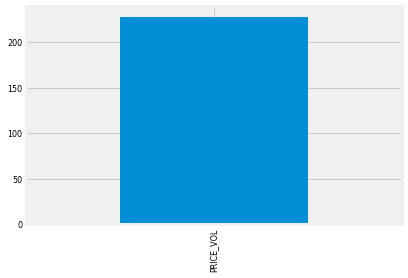

In [6]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']



btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]
print (btc_data.head())
plot_missing_values(btc_data)
btc_data.to_csv('btc_data.csv')
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)
print (btc_data.describe())

Only PRICE_VOL colum column has missing values.

0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the price vol column.


### 2)

Text(0.5, 0, 'date')

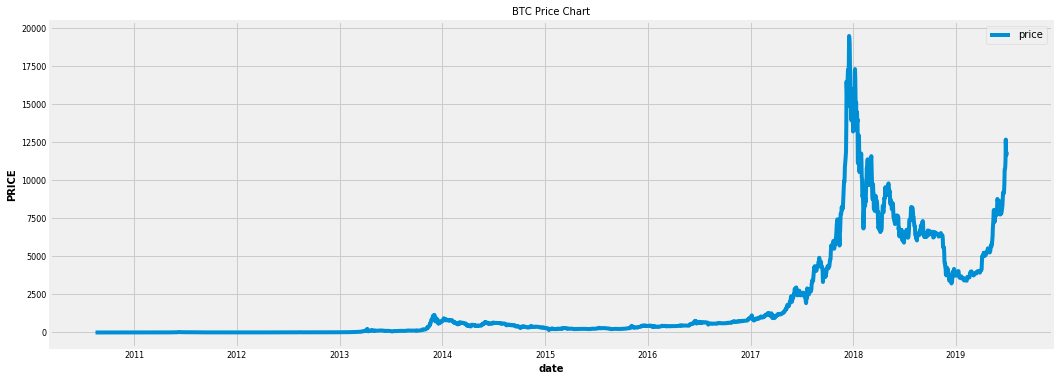

In [7]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')

               PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
2010-08-17 -0.448879   -0.313495   -0.534373 -0.614176   3.109663   
2010-08-18 -0.448880   -0.313497   -0.540073 -0.661082   1.865370   
2010-08-19 -0.448882   -0.313496   -0.526801 -0.743868   1.759482   
2010-08-20 -0.448882   -0.313496   -0.540073 -0.716115   1.671825   
2010-08-21 -0.448882   -0.313496   -0.540073 -0.729967   1.671825   

            MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  MONEY_SUPPLY  \
2010-08-17        1.053534   -0.401345   -1.088262  -0.400393     -2.275506   
2010-08-18        0.692685   -0.401345   -1.088262  -0.400393     -2.273790   
2010-08-19        0.773439   -0.401345   -1.088262  -0.400393     -2.272020   
2010-08-20        0.812879   -0.401345   -1.088262  -0.400393     -2.270224   
2010-08-21        1.974750   -0.401345   -1.088262  -0.400393     -2.267656   

            BCH_PRICE  
2010-08-17  -0.788172  
2010-08-18  -0.788172  
2010-08-19  -0.788172  
2010-08-20  -0

/Users/jinlei/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


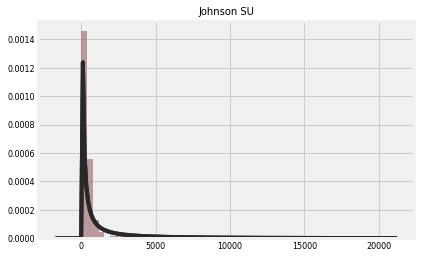

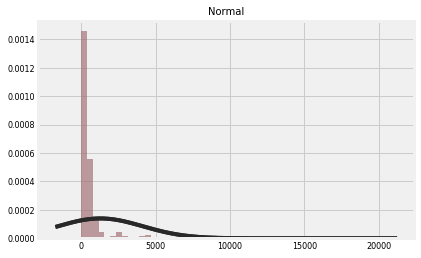

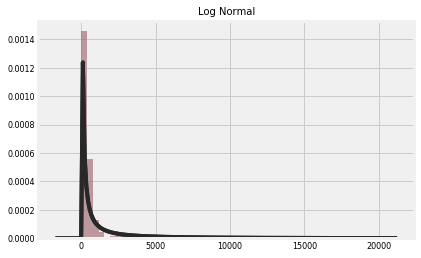

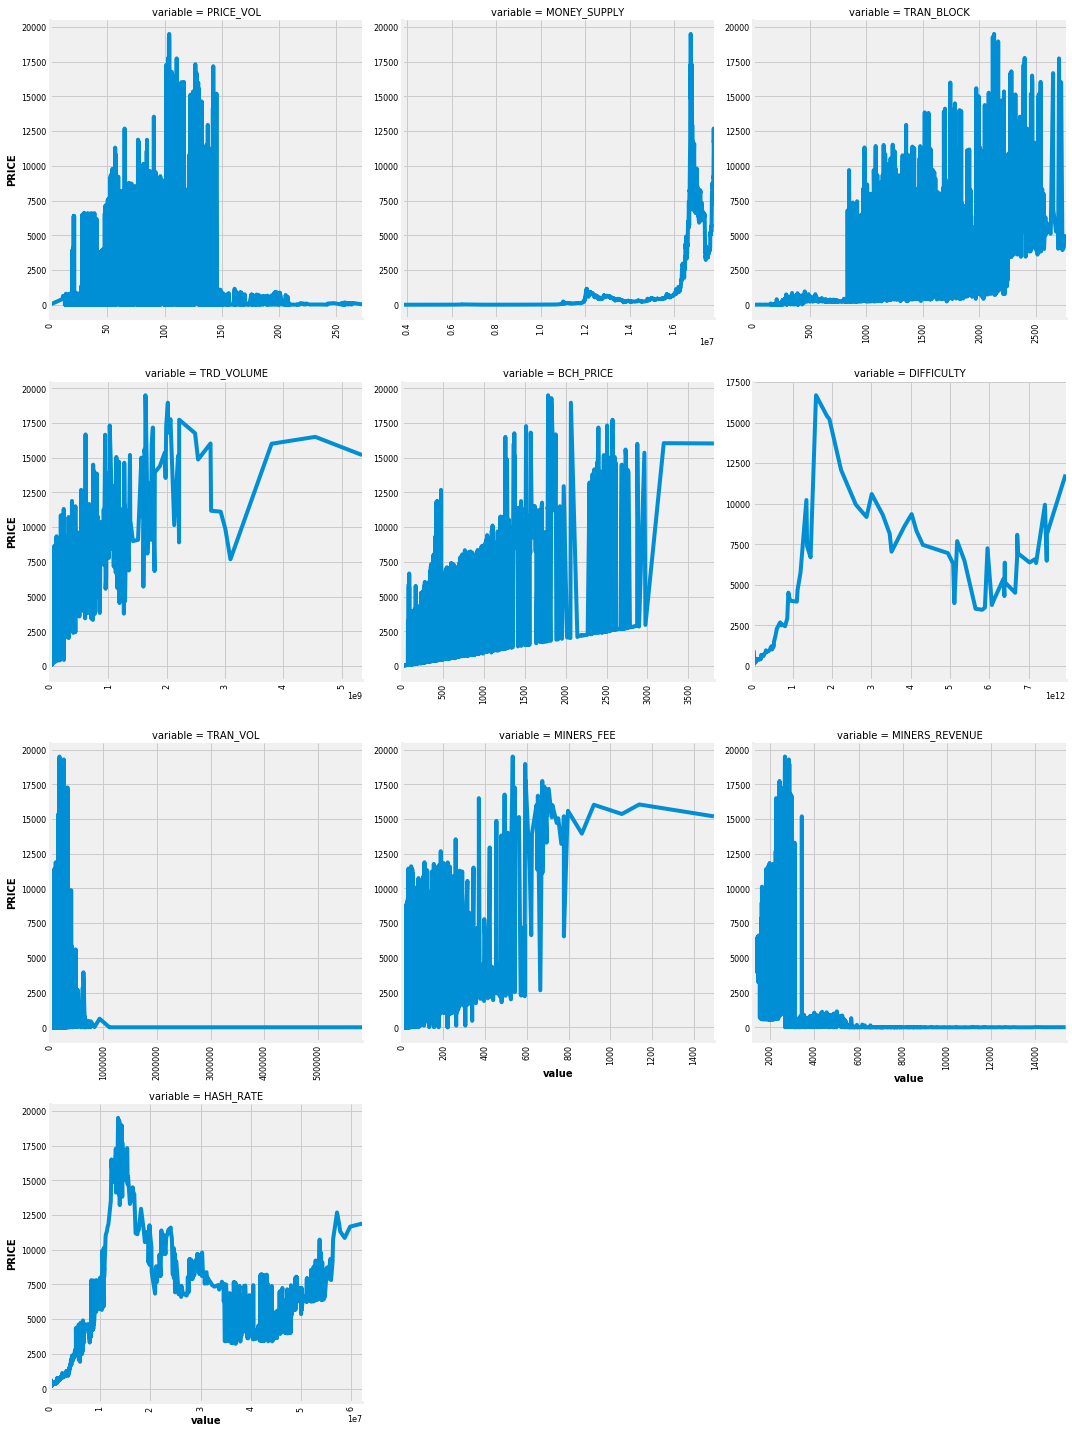

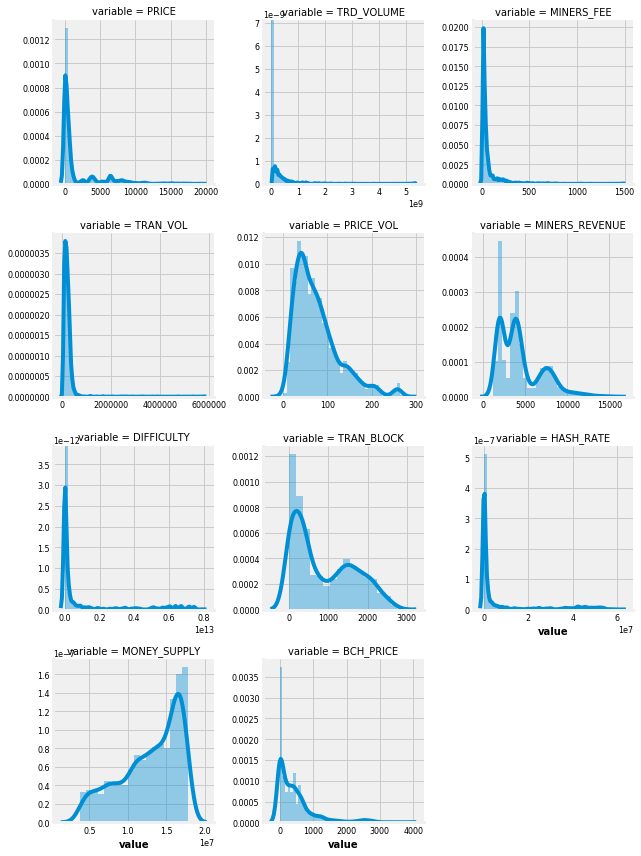

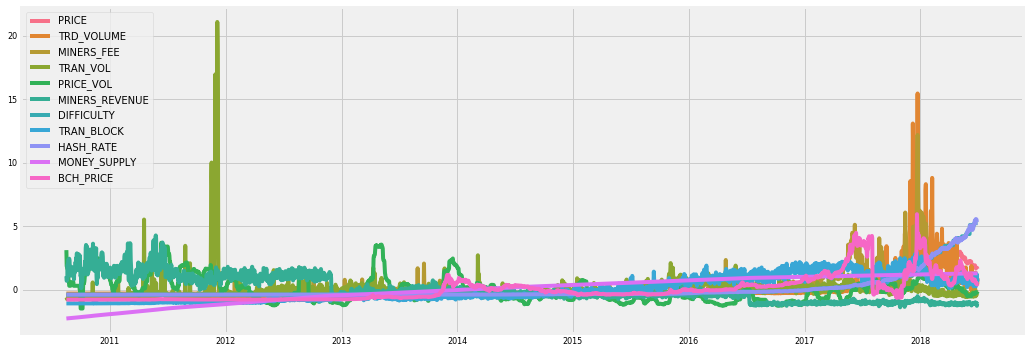

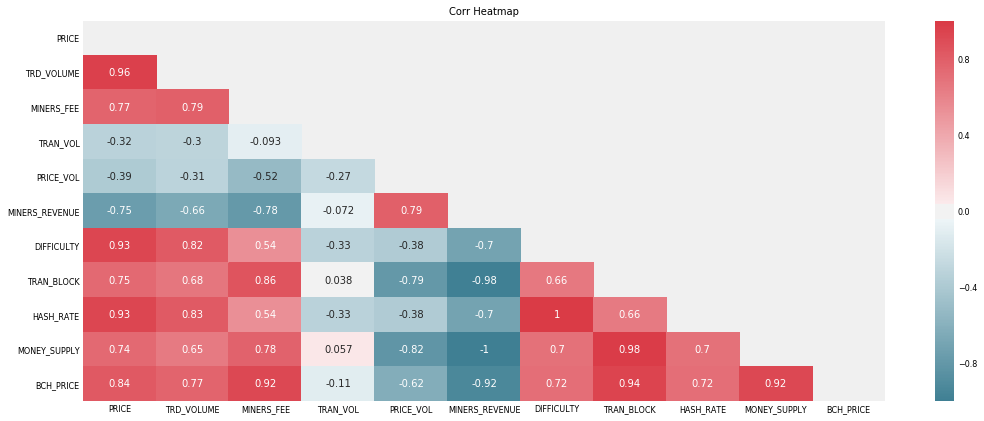

In [8]:
# lets split our data set before we do analysis on data set to make testing phase completely independent
target = 'PRICE'
base_features = btc_data.columns

train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train =  btc_data.loc[train_mask][base_features]
y_train =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid =  btc_data.loc[valid_mask][base_features]
y_valid = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test =  btc_data.loc[test_mask][base_features]
y_test =  pd.DataFrame(btc_data.loc[test_mask][target])

missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)
#using constant imputer for price volatility and standard scaler for normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
    
X_train = preprocessing_pipeline(X_train, train=True)
X_valid = preprocessing_pipeline(X_valid, train=False)
X_test = preprocessing_pipeline(X_test, train=False)

print(X_train.head())
X_train.describe()
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)
# print(list(base_features))
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

plot_distributions(btc_data)

#plot all columns in same chart 
plt.figure(figsize=(16,6))

sns.lineplot(data=X_train, dashes=False)
train_corr=X_train.cov()
plot_corr_heatmap(train_corr)

highly correlated

1)Money supply and transections per block 

2)BCH price and transections per block 

3) Market cap and difficulty of mining bitcoin

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

7) market cap and hash rate

Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)


We should drop difficulty as it is highly correlated with hashrate and trd volume.

### Observations

1) We have missing values for price volatility

2) Std dev of most of the columns is pretty high since 2010

3) We should reduce highly correlated features (this can be done using greedy algorithms or relying on L1 regularization of NNs)

4) Standardised features are not stationary which is evident from high shocks(non constant volatility) in the time series plot.



# ##benchmark

In [9]:
#### data processing Utils
def create_lagged_features(X, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    lagged_dfs = [ X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return pd.concat(lagged_dfs, axis=1)

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    if dropna:
        leading_df = leading_df.dropna()
    return pd.concat(leading_df, axis=1)
def get_avg_model_preds(y_val):
    y_preds = []
    for index, val in y_val.iterrows():
        ind_in_full_data = btc_data.index.get_loc(index)
        pred = btc_data.iloc[ind_in_full_data-28:ind_in_full_data]['PRICE'].mean()
        y_preds.append(np.ones(7)*pred)
    return y_preds

def get_last_val_preds(y_val):
    y_preds = []
    for index, val in y_val.iterrows():
        ind_in_full_data = btc_data.index.get_loc(index)
        pred = btc_data.iloc[ind_in_full_data-1]['PRICE']
        y_preds.append(np.ones(7)*pred)
    return y_preds

X_train_lagged = create_lagged_features(X_train, lag=28)[28:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[28:-7]
X_valid_lagged = create_lagged_features(X_valid, lag=28)[28:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[28:-7]
X_test_lagged = create_lagged_features(X_test, lag=28)[28:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[28:-7]
last_val_preds = get_last_val_preds(y_valid_leading)
avg_model_preds = get_avg_model_preds(y_valid_leading)

print("avg benchmark score: ", mean_absolute_error(y_valid_leading, avg_model_preds))
print("last val benchmark score: ", mean_absolute_error(y_valid_leading, last_val_preds))

avg benchmark score:  554.3354632715697
last val benchmark score:  309.17370001833166


In [21]:
btc_data

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE
2010-08-17,0.076900,8.259829e+02,6.700000e-01,48276.000000,242.026750,7350.670000,5.120000e+02,1.000000,4.129304e-03,3739600.0,0.07
2010-08-18,0.074000,1.420800e+02,0.000000e+00,35791.000000,176.560915,6450.000000,5.120000e+02,1.000000,4.120896e-03,3746050.0,0.07
2010-08-19,0.068800,1.944288e+02,1.560000e+00,13756.000000,170.989829,6651.560000,5.120000e+02,1.000000,4.022044e-03,3752700.0,0.07
2010-08-20,0.066700,2.271802e+02,0.000000e+00,21143.000000,166.377965,6750.000000,5.120000e+02,1.000000,3.970459e-03,3759450.0,0.07
2010-08-21,0.066899,4.737787e+02,0.000000e+00,17456.000000,166.377965,9650.000000,5.120000e+02,1.000000,4.134758e-03,3769100.0,0.07
2010-08-22,0.066400,1.295198e+03,0.000000e+00,29971.000000,131.302222,8650.000000,5.120000e+02,1.000000,4.061357e-03,3777750.0,0.07
2010-08-23,0.066000,2.641320e+02,0.000000e+00,11325.000000,131.302222,10600.000000,5.120000e+02,1.000000,4.079537e-03,3788350.0,0.07
2010-08-24,0.066889,6.675522e+02,0.000000e+00,11639.000000,112.610790,10650.000000,5.120000e+02,1.000000,4.319510e-03,3799000.0,0.07
2010-08-25,0.066500,1.906555e+02,8.000000e-01,7927.000000,112.610790,10750.800000,5.120000e+02,1.000000,4.632202e-03,3809750.0,0.07
2010-08-26,0.066499,3.666090e+02,0.000000e+00,18406.000000,94.194871,10800.000000,5.120000e+02,2.000000,4.933986e-03,3820550.0,0.07


In [10]:
class DLEngine:
    
    def __init__(self, data):
        self.raw_data = data
        
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.performance_history=None
        
        self.preprocess_params = {"imputer": None,
                                  "normalizer": None,
                                  "boxcox_X_lam": {},
                                  "boxcox_y_lam": None}
        self.model = {"SNN": None,
                     "LSTM": None,
                     "GRU":None}
        
        
    def train_test_split(self, base_features, target='PRICE'):
        # lets split our data set before we do analysis on data set to make testing phase completely independent
        train_mask = (self.raw_data.index >= '2010-01-01') & (self.raw_data.index <= '2018-06-30')
        valid_mask = (self.raw_data.index >= '2018-07-01') & (self.raw_data.index <= '2018-12-31')
        test_mask = (self.raw_data.index >= '2019-01-01') & (self.raw_data.index <= '2019-06-30')

        self.X_train =  self.raw_data.loc[train_mask][base_features]
        self.y_train =  pd.DataFrame(self.raw_data.loc[train_mask][target])

        self.X_valid =  self.raw_data.loc[valid_mask][base_features]
        self.y_valid = pd.DataFrame(self.raw_data.loc[valid_mask][target])

        self.X_test =  self.raw_data.loc[test_mask][base_features]
        self.y_test =  pd.DataFrame(self.raw_data.loc[test_mask][target])
    
    # preprocessing:
    def __impute(self, X, train=False, strategy='constant'):
        ind = X.index
        col = X.columns
        if train:
            #using constant imputer for price volatility and standard scaler for normalization
            self.preprocess_params["imputer"] = SimpleImputer(strategy=strategy)
            X = pd.DataFrame(self.preprocess_params["imputer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["imputer"].transform(X), columns=col, index=ind)
        return X
    
    def __boxcox(self, X, is_X=True, train=False):
        '''is_X: True, boxcox for X; False, boxcox for y
        '''
        ind = X.index
        res = pd.DataFrame(index=ind)
        for col_name, series in X.iteritems():
            if train:
                bc = boxcox(series)
                res[col_name] = bc[0]
                if is_X:
                    self.preprocess_params["boxcox_X_lam"][col_name] = bc[1]
                else:
                    self.preprocess_params["boxcox_y_lam"] = bc[1]
            else:
                if is_X:
                    lam = self.preprocess_params["boxcox_X_lam"][col_name]
                else:
                    lam = self.preprocess_params["boxcox_y_lam"]
                res[col_name] = boxcox(series, lmbda=lam)
        return res
    
    def __boxcox_inv(self, y, lmbda):
        '''inverse boxcox transformation
        '''
        if lmbda == 0:
            return np.exp(y)
        else:
            return np.power(lmbda * y + 1, 1 / lmbda)
    
    def __normalize(self, X, train=False):
        ind = X.index
        col = X.columns
        if train:
            #normalizer
            self.preprocess_params["normalizer"] = StandardScaler()
            X = pd.DataFrame(self.preprocess_params["normalizer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["normalizer"].transform(X), columns=col, index=ind)
        return X
    
    def preprocessing(self, impute=True, boxcox=True, normalize=True, **kwargs):
        '''other parameters: strategy
        '''
        if impute:
            self.X_train = self.__impute(self.X_train, train=True, strategy=kwargs['strategy'])
            self.X_valid = self.__impute(self.X_valid, train=False, strategy=kwargs['strategy'])
            self.X_test = self.__impute(self.X_test, train=False, strategy=kwargs['strategy'])
        
        if boxcox:
            self.X_train = self.__boxcox(1 + self.X_train, is_X=True, train=True)
            self.y_train = self.__boxcox(1 + self.y_train, is_X=False, train=True)
            self.X_valid = self.__boxcox(1 + self.X_valid, is_X=True, train=False)
            self.y_valid = self.__boxcox(1 + self.y_valid, is_X=False, train=False)
            self.X_test = self.__boxcox(1 + self.X_test, is_X=True, train=False)
            self.y_test = self.__boxcox(1 + self.y_test, is_X=False, train=False)
        
        if normalize:
            self.X_train = self.__normalize(self.X_train, train=True)
            self.X_valid = self.__normalize(self.X_valid, train=False)
            self.X_test = self.__normalize(self.X_test, train=False)
    
    # feature engineering:
    def __create_lagged_features(self, X, lag):
        """
        This function creates the lagged feature dataframe specifically useful for time series modelling
        """
        lagged_dfs = [X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
        return pd.concat(lagged_dfs, axis=1)

    def __create_leading_targets(self, X, lead):
        """
        This function creates leading targets specifically useful for predicting over multiple periods
        """
        leading_df = [X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
        return pd.concat(leading_df, axis=1)
  

    def __create_3d_lagged_features(self, X, lag):
        x_array=[]
        for i in range(len(X)-lag):
            x_array.append(X.iloc[i:i+lag,:].as_matrix())
        x_array=np.asarray(x_array)
        return x_array
    
    def munge(self):
        self.X_train = self.__create_lagged_features(self.X_train, lag=28)[28:-7]
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[28:-7]
        self.X_valid = self.__create_lagged_features(self.X_valid, lag=28)[28:-7]
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[28:-7]
        self.X_test = self.__create_lagged_features(self.X_test, lag=28)[28:-7]
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[28:-7]

    def munge_3d(self):
        self.X_train = self.__create_3d_lagged_features(self.X_train, lag=28)
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[:-28]
        self.X_valid = self.__create_3d_lagged_features(self.X_valid, lag=28)
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[:-28]
        self.X_test = self.__create_3d_lagged_features(self.X_test, lag=28)
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[:-28]

    def build_snn(self, layers, neurons, regl=0.01, summary=True):
        '''simple neural network
        '''
        self.model["SNN"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["SNN"].add(Dense(output_dim, input_dim=input_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        else:
            self.model["SNN"].add(Dense(neurons, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            for _ in range(layers-2):
                self.model["SNN"].add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            self.model["SNN"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["SNN"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["SNN"].summary())

    def build_lstm(self, layers, neurons,dropout_rate, regl=0.01, summary=True):
        '''LSTM
        '''
        self.model["LSTM"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["LSTM"].add(LSTM(output_dim, recurrent_dropout=dropout_rate,input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["LSTM"].add(LSTM(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["LSTM"].add(LSTM(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["LSTM"].add(LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["LSTM"].add(LSTM(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["LSTM"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["LSTM"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["LSTM"].summary())

    def build_gru(self, layers, neurons,dropout_rate=0.5, regl=0.01, summary=True):
        '''GRU
        '''
        self.model["GRU"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["GRU"].add(GRU(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["GRU"].add(GRU(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["GRU"].add(GRU(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["GRU"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["GRU"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["GRU"].summary())
      
    def train(self, model, epochs=40):
        """model: SNN, LSTM, GRU, RNN
        """
        self.performance_history = self.model[model].fit(self.X_train, self.y_train, epochs=epochs,
                                                         validation_data=(self.X_valid, self.y_valid))
    # predict
    def predict(self, model, X):
        y_pred = self.model[model].predict(X)
        if self.preprocess_params["boxcox_y_lam"]:
            y_pred = self.__boxcox_inv(y_pred, self.preprocess_params["boxcox_y_lam"]) - 1
        return y_pred
    
    # evaluate:
    def score(self, model, X, y_true):
        y_pred = self.predict(model, X)
        return mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))
    
    def result_evaluation(self, model):
        pyplot.plot(self.performance_history.history['loss'], label='train', color='brown')
        pyplot.plot(self.performance_history.history['val_loss'], label='valid', color='blue')
        pyplot.title(model+" training loss vs. validation loss")
        pyplot.legend()
        pyplot.show()

# Part3 Q2: Simple Neural Network

In [11]:
#simple neural network
np.random.seed(0)
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(strategy='constant')
engine.munge()
engine.build_snn(2, 50, regl=0.05, summary=True)
engine.train('SNN')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1

/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                15450     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 357       
Total params: 15,807
Trainable params: 15,807
Non-trainable params: 0
_________________________________________________________________
None
Train on 2840 samples, validate on 149 samples
Epoch 1/40
2840/2840 [==============================] - 1s 267us/step - loss: 6.4212 - val_loss: 4.1737
Epoch 2/40
2840/2840 [==============================] - 0s 60us/step - loss: 2.9934 - val_loss: 4.5700
Epoch 3/40
2840/2840 [==============================] - 0s 89us/step - loss: 2.0445 - val_loss: 4.3187
Epoch 4/40
2840/2840 [==============================] - 0s 84us/step - loss: 1.6486 - val_loss: 3.8173
Epoch 5/40
2840/2840 [=========================

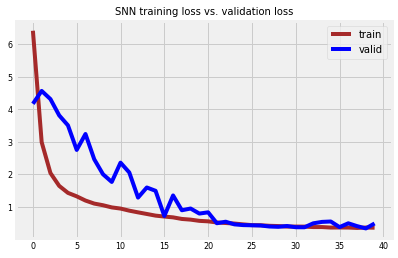

Training  error: MAE: 212.75690419712978 RMSE 771.5184456397619
validation error: MAE 961.8859235583843 RMSE 1082.5244734423402
Testing error: MAE 1938.3857809277345 RMSE 2223.898577252878


In [12]:
engine.result_evaluation('SNN')
print ("Training  error: MAE:",engine.score("SNN", engine.X_train, y_train_true)[0],
       "RMSE",engine.score("SNN", engine.X_train, y_train_true)[1])
print ("validation error: MAE",engine.score("SNN", engine.X_valid, y_valid_true)[0],      
       "RMSE",engine.score("SNN", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE",engine.score("SNN", engine.X_test, y_test_true)[0],      
       "RMSE",engine.score("SNN", engine.X_test, y_test_true)[1])

# Part3 Q3: LSTM

In [22]:
#LSTM
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_lstm(3, 32,dropout_rate=0.0, regl=0.0, summary=True)
engine.train('LSTM')

/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: FutureWarning: Metho

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 28, 32)            5632      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 231       
Total params: 14,183
Trainable params: 14,183
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 4s 2ms/step - loss: 3.8658 - val_loss: 5.7353
Epoch 2/40
2847/2847 [==============================] - 3s 1ms/step - loss: 1.2157 - val_loss: 3.7853
Epoch 3/40
2847/2847 [==============================] - 3s 1ms/step - loss: 0.8595 - val_loss: 3.7403
Epoch 4/40
2847/2847 [

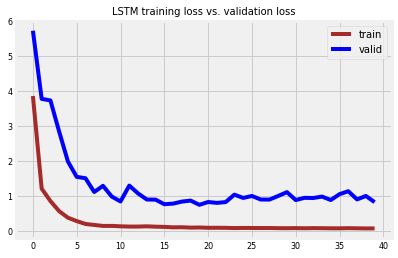

Training  error: MAE: 79.22421729620909 RMSE: 294.7806598476437
validation error: MAE: 2291.043037589718 RMSE: 2535.052207746172
Testing error: MAE: 2187.6564388671864 RMSE: 2246.0350593116154


In [23]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('LSTM')
print ("Training  error: MAE:",engine.score("LSTM", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("LSTM", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("LSTM", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("LSTM", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_test, y_test_true)[1])

# Part3 Q4

In [15]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0, regl=0.0, summary=True)
engine.train('GRU')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
print ("Training  error:",engine.score("GRU", engine.X_train, y_train_true))
print ("validation error:",engine.score("GRU", engine.X_valid, y_valid_true))

/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: FutureWarning: Metho

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 7)                 399       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
Total params: 455
Trainable params: 455
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 4s 1ms/step - loss: 5.8874 - val_loss: 10.9390
Epoch 2/40
2847/2847 [==============================] - 3s 1ms/step - loss: 5.5227 - val_loss: 10.0374
Epoch 3/40
2847/2847 [==============================] - 3s 1ms/step - loss: 4.6159 - val_loss: 8.7039
Epoch 4/40
2847/2847 [==============================] - 3s 930us/step - loss: 3.4518 - val_loss: 7.6081
Epoch 5/40
2847/2847 [==============================] 

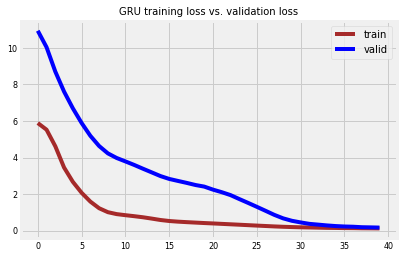

Training  error: MAE: 216.75038253613633 RMSE: 907.2879398793702
validation error: MAE: 598.5228732277102 RMSE: 703.9445425489079
Testing error: MAE: 540.3758651620902 RMSE: 853.8256299228098


In [16]:
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])

# Part3 Q5
Build and train an RNN model with a GRU layer and recurrent dropout and print the train
and validation loss for each epoch

In [17]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: FutureWarning: Metho

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7)                 399       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 56        
Total params: 455
Trainable params: 455
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 4s 1ms/step - loss: 1561507.1585 - val_loss: 11.2569
Epoch 2/40
2847/2847 [==============================] - 3s 1ms/step - loss: 188596.8612 - val_loss: 11.1963
Epoch 3/40
2847/2847 [==============================] - 3s 959us/step - loss: 77555.9452 - val_loss: 11.1325
Epoch 4/40
2847/2847 [==============================] - 2s 817us/step - loss: 42626.4477 - val_loss: 11.0565
Epoch 5/40
2847/2847 [=========

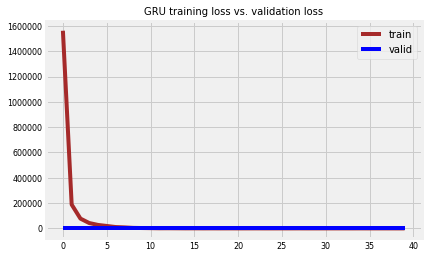

Training  error: MAE: 1224.927875472032 RMSE: 3073.087263398802
validation error: MAE: 6349.097048154165 RMSE: 6418.3957895305
Testing error: MAE: 4869.571101439368 RMSE: 5119.878009173591


In [18]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])

# Part3 Q6
Add an additional GRU layer to (5) above with dropout and recurrent dropout and print
the train and validation loss

In [19]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(3, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/jinlei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: FutureWarning: Metho

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 28, 32)            4224      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 231       
Total params: 10,695
Trainable params: 10,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 6s 2ms/step - loss: 5.3261 - val_loss: 8.6689
Epoch 2/40
2847/2847 [==============================] - 5s 2ms/step - loss: 2.9436 - val_loss: 4.4400
Epoch 3/40
2847/2847 [==============================] - 4s 2ms/step - loss: 1.5484 - val_loss: 3.0025
Epoch 4/40
2847/2847 [

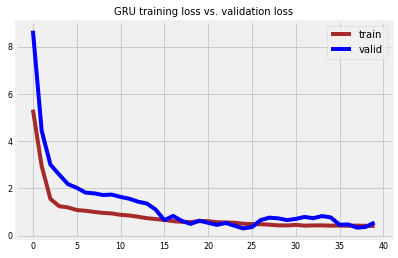

Training  error: MAE: 392.5658254477489 RMSE: 1049.2792598897313
validation error: MAE: 2235.5986972816218 RMSE: 2518.0438835283744
Testing error: MAE: 2165.3674331156108 RMSE: 2365.7390293939247


In [20]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])